# Лабораторная работа №1

### работу выполнил Смирнов Андрей Сергеевич М3337


## Выгрузка данных из тензорфлоу и придание им числового вида

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import StandardScaler

# Загрузка датасета CIFAR-10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [2]:
train_len = 5000
test_len = 1000
train_images = train_images[:train_len]
train_labels = train_labels[:train_len]
test_images = test_images[-test_len:]
test_labels = test_labels[-test_len:]


# Предобработка данных
# Преобразование значений пикселей к диапазону от 0 до 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


# Нормализация данных (стандартизация)
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images.reshape(train_images.shape[0], -1)).reshape(train_images.shape)
test_images = scaler.transform(test_images.reshape(test_images.shape[0], -1)).reshape(test_images.shape)

# Вывод размеров данных
print("Размеры обучающей выборки:", train_images.shape, train_labels.shape)
print("Размеры тестовой выборки:", test_images.shape, test_labels.shape)

# Преобразование изображений в двумерные массивы
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)
train_labels_flat = train_labels.flatten()
test_labels_flat = test_labels.flatten()
print(train_images_flat)
print(train_labels_flat)

Размеры обучающей выборки: (5000, 32, 32, 3) (5000, 1)
Размеры тестовой выборки: (1000, 32, 32, 3) (1000, 1)
[[-0.97621554 -1.0068297  -0.8550109  ... -0.06853879 -0.5380007
  -0.6391327 ]
 [ 0.3037721   0.54991555  0.6665136  ...  0.23622699  0.10691439
   0.43790096]
 [ 1.6646008   1.6057948   1.500898   ... -0.723785   -0.6323785
  -0.45962706]
 ...
 [ 0.4789283   0.36039874  0.1511586  ... -1.3028398  -0.75821555
  -0.45962706]
 [ 0.3037721   0.21149267 -0.09424865 ...  1.0133795   1.9000926
  -0.01086311]
 [-1.1648452  -1.4129372  -1.370366   ...  0.43432465  0.24848108
  -0.2202863 ]]
[6 9 9 ... 5 4 6]


## Реализация метода kNN

In [3]:
from scipy import stats
import math

from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

class MyKNearestNeighbors:
    weights: np.ndarray = None
    kernels = {
        'uniform': lambda x: stats.uniform.pdf(x, loc=-1, scale=2),
        'gaussian': lambda x: 1/math.sqrt(2*math.pi)*math.exp(-(x**2/2)),
        'triangular': lambda x: max(0,1-abs(x)),
        'epanechnikov': lambda x: max(0, 0.75*(1-x**2))
    }
    metrics = ['manhattan', 'euclidean', 'cosine']
    xs: pd.DataFrame = None
    ys: np.ndarray = None
    n_classes: int = 0

    def __init__(
            self,
            n_neighbors: int = 3,
            window_type: str = 'non_fixed',
            window_param: float | None = None,
            metric: str = 'euclidean',
            weights: str = 'gaussian',
            leaf_size: int = 30
    ):
        self.n_neighbors = n_neighbors
        self.window = window_param if window_type == 'fixed' else None
        self.leaf_size = leaf_size
        self.metric = metric
        self.kernel = self.kernels[weights]

    def fit(self, X, y, weights=None):
        self.xs = X
        self.ys = y
        self.cls_num = len(np.unique(y))
        self.weights = weights if weights is not None else np.array([1.0] * len(y))
        return self

    def predict(self, X):
        n_neighbors = self.n_neighbors + 1 if self.window is None else self.n_neighbors
        dists, ids = NearestNeighbors(n_neighbors=n_neighbors, metric=self.metric).fit(self.xs).kneighbors(X, n_neighbors=n_neighbors)
        
        cls = [self.ys[i] for i in ids]         # only for int one-dimension
        ws = [[self.weights[j] for j in i] for i in ids]

        length = len(X)
        results = np.array([0]*length)
        for i in range(length):
            d, c, w = dists[i], cls[i], ws[i]
            scores = [0]*self.cls_num
            
            for j in range(len(d)-1):
                kernel_arg = d[j]/(self.window if self.window else d[-1])
                scores[c[j]] += self.kernel(kernel_arg) * w[j]
            results[i] = scores.index(max(scores))

        return results

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Пример использования на своей модели и уже готовой библиотечной
for model in [MyKNearestNeighbors, KNeighborsClassifier]:
    # Создание и обучение модели
    knn = model(n_neighbors=3, weights='uniform', metric='euclidean')
    knn.fit(train_images_flat, train_labels_flat)
    
    # Предсказание меток для тестовых данных
    predicted_labels = knn.predict(test_images_flat)
    
    # Оценка точности предсказаний
    accuracy = accuracy_score(test_labels_flat, predicted_labels)
    print(f"Точность классификации модели {model}: {accuracy}")

Точность классификации модели <class '__main__.MyKNearestNeighbors'>: 0.254
Точность классификации модели <class 'sklearn.neighbors._classification.KNeighborsClassifier'>: 0.254


Как видно из результатов, точность классификации совпадают для нашей и библиотечной модели хотя бы для этих гиперпараметрах, а значит мы движемся в правильном направлении! Теперь давайте перейдем к этапу подбора гиперпараметров

## Подбор гиперпараметров
Для этого будем использовать библиотеку optuna

In [5]:
import optuna

def my_objective(trial):
    # Определение гиперпараметров для настройки
    n_neighbors = trial.suggest_int('n_neighbors', 1, 100)
    # weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', MyKNearestNeighbors.metrics)
    kernel = trial.suggest_categorical('kernel', MyKNearestNeighbors.kernels.keys())
    window_type = trial.suggest_categorical('window_type', ['non_fixed', 'fixed'])
    window_param = trial.suggest_float('window_param', 0.01, 1) if window_type == 'fixed' else None
    
    knn = MyKNearestNeighbors(
        n_neighbors=n_neighbors, 
        weights=kernel, 
        metric=metric,
        window_type=window_type,
        window_param=window_param,
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(test_images_flat)
    return accuracy_score(test_labels_flat, y_pred)

# Создание объекта study для оптимизации гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100, show_progress_bar=True)

# Вывод лучших найденных значений гиперпараметров
best_params = study.best_params
print(f"Лучшие гиперпараметры для моей модели: {best_params}")

[I 2024-03-26 21:13:15,803] A new study created in memory with name: no-name-100508b9-4463-4e8b-882e-eb785c5785dc


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-26 21:13:19,673] Trial 0 finished with value: 0.107 and parameters: {'n_neighbors': 69, 'metric': 'manhattan', 'kernel': 'epanechnikov', 'window_type': 'fixed', 'window_param': 0.4958794009343935}. Best is trial 0 with value: 0.107.
[I 2024-03-26 21:13:26,885] Trial 1 finished with value: 0.296 and parameters: {'n_neighbors': 88, 'metric': 'cosine', 'kernel': 'uniform', 'window_type': 'non_fixed'}. Best is trial 1 with value: 0.296.
[I 2024-03-26 21:13:27,447] Trial 2 finished with value: 0.267 and parameters: {'n_neighbors': 65, 'metric': 'euclidean', 'kernel': 'epanechnikov', 'window_type': 'non_fixed'}. Best is trial 1 with value: 0.296.
[I 2024-03-26 21:13:27,823] Trial 3 finished with value: 0.365 and parameters: {'n_neighbors': 24, 'metric': 'cosine', 'kernel': 'epanechnikov', 'window_type': 'non_fixed'}. Best is trial 3 with value: 0.365.
[I 2024-03-26 21:13:28,214] Trial 4 finished with value: 0.344 and parameters: {'n_neighbors': 33, 'metric': 'cosine', 'kernel': 'g

In [5]:
import optuna

def lib_objective(trial):
    # Определение гиперпараметров для настройки
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors, 
        weights=weights, 
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(test_images_flat)
    return accuracy_score(test_labels_flat, y_pred)

# Создание объекта study для оптимизации гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(lib_objective, n_trials=100, show_progress_bar=True)

# Вывод лучших найденных значений гиперпараметров
best_params = study.best_params
print(f"Лучшие гиперпараметры для библиотечной модели: {best_params}")

[I 2024-03-26 21:55:40,166] A new study created in memory with name: no-name-bee4dccd-460b-421e-8ab5-a78897450cb1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-26 21:55:40,637] Trial 0 finished with value: 0.258 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.258.
[I 2024-03-26 21:55:41,061] Trial 1 finished with value: 0.281 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.281.
[I 2024-03-26 21:55:41,493] Trial 2 finished with value: 0.259 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 1 with value: 0.281.
[I 2024-03-26 21:55:41,890] Trial 3 finished with value: 0.22 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'brute'}. Best is trial 1 with value: 0.281.
[I 2024-03-26 21:55:42,314] Trial 4 finished with value: 0.272 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.281.
[I 2024-03-26 21:55:42,725] Trial 5 finished with value: 0.258 and parameters: {'n_neighbors': 9, 'we

## Графики в зависимости от n_neighbours и размера окна

In [10]:
def get_my_accuracy_by_neighbors(n_neighbors, images, labels):
    knn = MyKNearestNeighbors(
        n_neighbors=n_neighbors, 
        weights='epanechnikov', 
        metric='cosine',
        window_type='non_fixed',
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(images)
    return accuracy_score(labels, y_pred)

def get_lib_accuracy_by_neighbors(n_neighbors, images, labels):
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights='distance',
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(images)
    return accuracy_score(labels, y_pred)

def get_my_accuracy_by_window_size(window_size, images, labels):
    knn = MyKNearestNeighbors(
        n_neighbors=15, 
        weights='epanechnikov', 
        metric='cosine',
        window_type='fixed',
        window_param=window_size,
    )
    knn.fit(train_images_flat, train_labels_flat)
    y_pred = knn.predict(images)
    return accuracy_score(labels, y_pred)

### Для n_neighbors

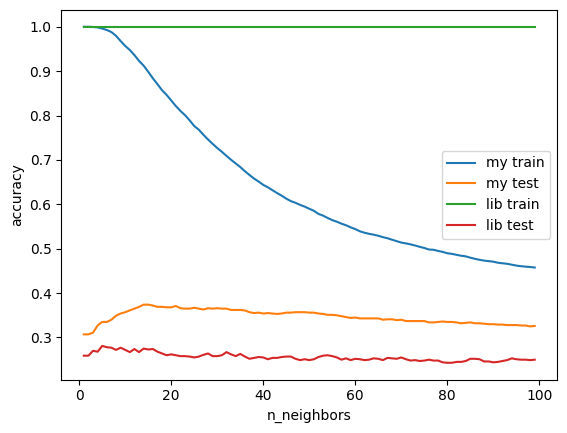

In [11]:
import matplotlib.pyplot as plt

neighbors_range = [k for k in range(1, 100)]

my_train = [get_my_accuracy_by_neighbors(k, train_images_flat, train_labels_flat) for k in neighbors_range]
lib_train = [get_lib_accuracy_by_neighbors(k, train_images_flat, train_labels_flat) for k in neighbors_range]
my_test = [get_my_accuracy_by_neighbors(k, test_images_flat, test_labels_flat) for k in neighbors_range]
lib_test = [get_lib_accuracy_by_neighbors(k, test_images_flat, test_labels_flat) for k in neighbors_range]

plt.plot(neighbors_range, my_train, label='my train')
plt.plot(neighbors_range, my_test, label='my test')
plt.plot(neighbors_range, lib_train, label='lib train')
plt.plot(neighbors_range, lib_test, label='lib test')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

### Для размера окна

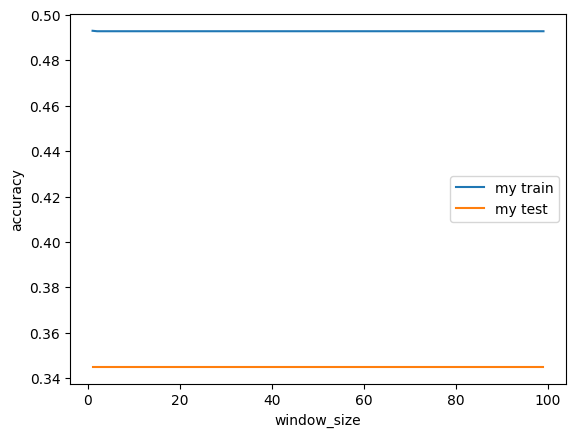

In [12]:
window_sizes = [k * 0.01 for k in range(1, 100)]
my_train = [get_my_accuracy_by_window_size(k, train_images_flat, train_labels_flat) for k in neighbors_range]
my_test = [get_my_accuracy_by_window_size(k, test_images_flat, test_labels_flat) for k in neighbors_range]


plt.plot(neighbors_range, my_train, label='my train')
plt.plot(neighbors_range, my_test, label='my test')
plt.legend()
plt.xlabel('window_size')
plt.ylabel('accuracy')
plt.show()

## Поиск аномалий

## Реализация LOWESS

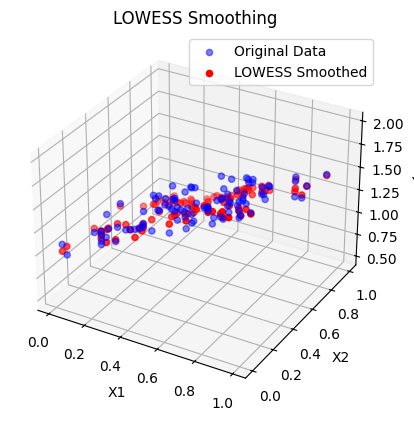

In [18]:
import numpy as np

def tricube_weight(d, bandwidth):
    """
    Функция весов для LOWESS. Возвращает вес для расстояния d, используя tricube-функцию.
    """
    w = (1 - np.abs(d / bandwidth) ** 3) ** 3
    return w * (np.abs(d) <= bandwidth)

def lowess_smoothing(x, y, bandwidth, weight_func=tricube_weight):
    """
    Реализация LOWESS (Locally Weighted Scatterplot Smoothing).
    """
    smoothed = []
    for i in range(len(x)):
        # Находим расстояния до всех точек
        distances = np.linalg.norm(x - x[i], axis=1)
        
        # Вычисляем веса для каждой точки
        weights = weight_func(distances, bandwidth)
        
        # Вычисляем взвешенное среднее значения для текущей точки
        weighted_sum = np.sum(weights * y)
        weighted_mean = weighted_sum / np.sum(weights)
        smoothed.append(weighted_mean)
    
    return np.array(smoothed)

# Пример использования
x = np.random.rand(100, 2)  # Двумерные данные
y = np.sin(x[:, 0]) + np.cos(x[:, 1]) + np.random.normal(0, 0.1, size=len(x))  # Добавляем шум
bandwidth = 0.2
smoothed = lowess_smoothing(x, y, bandwidth)

# Визуализация
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y, label='Original Data', color='blue', alpha=0.5)
ax.scatter(x[:, 0], x[:, 1], smoothed, label='LOWESS Smoothed', color='red')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
ax.set_zlabel('Y')
plt.title('LOWESS Smoothing')
plt.show()

In [26]:
distances = np.linalg.norm(train_images_flat - train_images_flat[0], axis=1)
distances

array([ 0.      , 69.54366 , 94.85495 , ..., 61.757248, 66.285355,
       65.66881 ], dtype=float32)

### Поиск аномалий

In [40]:
from sklearn.metrics import mean_squared_error

bandwidth = 40
# Применяем LOWESS к тренировочным данным
train_data_smoothed = lowess_smoothing(train_images_flat, train_labels_flat, bandwidth)

# Вычисляем ошибку до сглаживания
mse_before = mean_squared_error(train_labels_flat, train_data_smoothed)

threshold = 1
# Определяем аномалии на тренировочных данных
anomalies_before = np.abs(train_labels_flat - train_data_smoothed) > threshold

# Применяем LOWESS к тестовым данным
test_data_smoothed = lowess_smoothing(test_images_flat, test_labels_flat, bandwidth)

# Вычисляем ошибку после сглаживания на тестовых данных
mse_after = mean_squared_error(test_labels_flat, test_data_smoothed)

# Определяем аномалии на тестовых данных
anomalies_after = np.abs(test_labels_flat - test_data_smoothed) > threshold

print("on train: ", anomalies_before)
print("on test: ", anomalies_after)

on train:  [False False False ... False False False]
on test:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False  True False
 False False False False False False False False False False False False
  True False False False False False False False False False 

In [41]:
print("train percent: ", len(anomalies_before[anomalies_before == True]) / len(train_labels_flat))
print("test percent: ", len(anomalies_after[anomalies_after == True]) / len(test_labels_flat))

train percent:  0.0904
test percent:  0.03


### Проставление весов для аномалий и сравнение результатов с аномалиями и без

In [42]:
def get_weight(normal_weight, anomaly_weight, is_anomaly):
    return [anomaly_weight if is_anomaly[i] else normal_weight for i in range(len(is_anomaly))]

In [48]:
def get_my_accuracy(weights=None):
    knn = MyKNearestNeighbors(
        n_neighbors=15,
        metric='cosine',
        weights='epanechnikov',
    ).fit(train_images_flat, train_labels_flat, weights)
    predict = knn.predict(test_images_flat)
    return accuracy_score(predict, test_labels_flat)

print("С аномалиями (моя версия): ", get_my_accuracy())
print("С взвешенными аномалиями (моя версия)", get_my_accuracy(get_weight(1, 0.1, anomalies_before)))

С аномалиями (моя версия):  0.374
С взвешенными аномалиями (моя версия) 0.364


In [51]:
def get_lib_accuracy(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(
        n_neighbors=5,
    ).fit(x_train, y_train)
    predict = knn.predict(x_test)
    return accuracy_score(predict, y_test)

anomalies_idxs = [i for i in range(len(anomalies_before)) if anomalies_before[i]]
anomaly_images, anomaly_labels = train_images_flat[anomalies_idxs], train_labels_flat[anomalies_idxs]
image_train_sampled, label_train_sampled = np.concatenate([train_images_flat, anomaly_images]), np.concatenate([train_labels_flat, anomaly_labels])

print("С аномалиями (библиотечная): ", get_lib_accuracy(train_images_flat, train_labels_flat, test_images_flat, test_labels_flat))
print("С взвешенными аномалиями (библиотечная):", get_lib_accuracy(image_train_sampled, label_train_sampled, test_images_flat, test_labels_flat))

С аномалиями (библиотечная):  0.272
С взвешенными аномалиями (библиотечная): 0.243
